# Final project

### Do what would make sense?

Month, itens and stores. Some itens can be more sold in some stores in specific months.

How can I found this?

01. To find sells by item, month and store. 
02. To find the stores that likely target store.
03. To do some encoding in categorical variables. 




In [25]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
import gc

from itertools import product

In [2]:
from IPython.core.display import display, HTML


## Reading the data

In [3]:
#import data
sales = pd.read_csv('..\\readonly\\final_project_data\\sales_train.csv.gz')
shops = pd.read_csv('..\\readonly\\final_project_data\\shops.csv')
items = pd.read_csv('..\\readonly\\final_project_data\\items.csv')
item_cats = pd.read_csv('..\\readonly\\final_project_data\\item_categories.csv')



In [4]:
def glimpse_data(df,title=''):
    first_row = '=' * 30 + title + 30 * '='
    
    
    str_html = (
        '<h2>%s</h2>'
        '<ul><li>Shape: %s</li>' 
        '<li>Head <br/>%s</li>'  
        '<li>Data types <br/>%s</li>'
        '<li>Describe <br/>%s</li>'
        '<li>Unique values <br/>%s</li>'
        '</ul>'
    %(str(title),
      str(df.shape),
      str(df.head().to_html()), 
      str(pd.DataFrame(df.dtypes,columns=['tipo']).to_html()),
      str(df.describe().to_html()),
      str(pd.DataFrame(df.nunique(),columns=['qtd']).to_html())
     )
    )
    display(HTML(str_html))
    
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [5]:
#A glimpse on dataframes
glimpse_data(sales,'Sales (sales)')
glimpse_data(shops, 'Shops (shops)')
glimpse_data(items, 'Items (items)')
glimpse_data(item_cats, 'Item categoties (item_cats)')



## Explroing Sales Data
### Type of data in Sales train 
<ul>
    <li>date: date</li>
    <li>date_block_num: categorical</li>
    <li>shop_id: categorical</li>
    <li>item_id: categorical</li>
    <li>item_price: numerical</li>
    <li> item_cnt_day: numerical</li>
</ul>


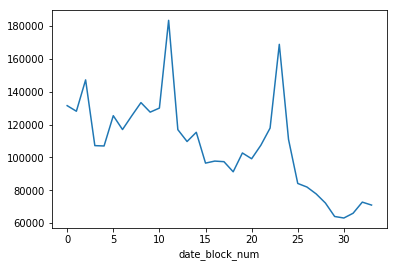

In [6]:
#sales['dt'] = pd.to_datetime(sales.date)
#print('%s to %s' %(str(min(sales.dt)), str(max( sales.dt))))
sr_qt = sales.groupby('date_block_num').sum()['item_cnt_day']
sr_qt.plot()

In [7]:
#when occurred the top sales 
sr_qt.sort_values(ascending=False)
print(sales[sales.date_block_num.isin(sr_qt.sort_values(ascending=False).index.values[:2])].groupby('date_block_num').max()['date'])
#Wow! Amazing decembers

#The trend looks like be a higher period the top on december and then a big lower.
#How do put it in model?
#fiding the minimu before the max
#sales[sales.date_block_num.isin(sr_qt.sort_values(ascending=False).index.values[:2])].groupby('date_block_num').min()

date_block_num
11    31.12.2013
23    31.12.2014
Name: date, dtype: object


In [8]:
sales.item_cnt_day = sales.item_cnt_day.clip(0,20)

## EDA

In [9]:

# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

c:\users\italo dell\appdata\local\programs\python\python35\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [10]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [11]:
glimpse_data(all_data)

## Starts of the modeling...

In [12]:
#splitting the data by the month
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [13]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

## We will do ensemble of models




In [14]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))

Test R-squared for linreg is 0.658842


In [15]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=5)
cdtr = dtr.fit(X_train.values, y_train)
pred_dtr = cdtr.predict(X_test)
print('Test R-squared for Decision Tree is %f' % r2_score(y_test, pred_dtr))

Test R-squared for Decision Tree is 0.597411


In [16]:
X_test_level2 = np.c_[pred_lr, pred_dtr] 

In [18]:
dbn_sel = [27, 28, 29, 30, 31, 32]
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

X_train_level2 = np.zeros([y_train_level2.shape[0], 2])
print(X_train_level2.shape)
# Now fill `X_train_level2` with metafeatures
t = 0
for cur_block_num in tqdm_notebook([27, 28, 29, 30, 31, 32]):
    new_X_train = all_data[all_data.date_block_num <  cur_block_num].drop(to_drop_cols, axis=1)
    new_y_train = all_data[all_data.date_block_num <  cur_block_num]['target'].values
    new_X_test = all_data[all_data.date_block_num ==  cur_block_num].drop(to_drop_cols, axis=1)
    lr = lr.fit(new_X_train.values, new_y_train)
    pred_lr = lr.predict(new_X_test.values)
    model = dtr.fit(new_X_train.values, new_y_train)
    pred_dtr = model.predict(new_X_test.values)
    for i,v in enumerate(list(zip(pred_lr,pred_dtr))):
        X_train_level2[t+i] = np.array([v[0],v[1]])
    
    t += len(pred_dtr)


(1376192, 2)


In [23]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=20)
# Train the model on training data
cls_rf = rf.fit(X_train_level2,y_train_level2);


In [24]:
train_preds = cls_rf.predict(X_train_level2)
r2_train_stacking = r2_score(y_train_level2,train_preds)

test_preds = cls_rf.predict(X_test_level2)
r2_test_stacking = r2_score(y_test,test_preds)

print('Train R-squared for stacking is %f' % r2_train_stacking)
print('Test  R-squared for stacking is %f' % r2_test_stacking)

Train R-squared for stacking is 0.910311
Test  R-squared for stacking is 0.471148
